## Assess FastSpecFit Stellar Mass Estimates

The goal of this notebook is to compare the stellar masses estimated using `FastSpecFit` (with and without DESI spectroscopy) against various other techniques.

John Moustakas  
Siena College  
2024 January 12

In [1]:
%%html 
<style>table { display: inline-block } </style>

| Catalog | IMF | H$_{0}$| Photometry | Spectroscopy | SPS Models | SFH Prior | $Z$ Prior | Dust Model | IR Model | AGN? | Nebular Lines | Reference |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| `fastphot` | Chabrier | 100 | *grzW1-W4* | None | FSPS (C3K+MIST) | [1] | $Z_{\odot}$ | $\propto \tau^{-0.7}$ | Draine & Li 2007 | No | Yes | [docs](https://fastspecfit.readthedocs.io/en/latest) |
| `fastspec` | Chabrier | 100 | *grzW1-W4* | All | FSPS (C3K+MIST) | [1] | $Z_{\odot}$ | $\propto \tau^{-0.7}$ | Draine & Li 2007 | No | Yes | [docs](https://fastspecfit.readthedocs.io/en/latest) |
| `Mar/CIGALE-AGN`       | Chabrier | 70 | *grzW1-W4* | None | BC03 (STELIB+Padova?) | $\tau e^{-t/\tau}$+bursts | $Z_{\odot}$ | Calzetti+2000 | Dale+2014 | Yes | Yes | [README](https://data.desi.lbl.gov/doc/releases/edr/vac/cigale/) |
| `Hu/CIGALE`        | Chabrier | 70 | *grzW1-W2* | 10-band synthesized | BC03 (STELIB+Padova?) | $\tau e^{-t/\tau}$ | (0.02-2.5)$Z_{\odot}$ | Charlot & Fall 2000 |Yes |  Draine+2014 | No | [Zou et al. 2023](https://arxiv.org/abs/2312.00300); [README](https://data.desi.lbl.gov/doc/releases/edr/vac/stellar-mass-emline) |
| `Kcorrect`        | Chabrier | 100 | *grzW1-W2* | None | BC03 (STELIB+Padova) | [2] | [2] | [2] | None | No | Yes | [docs](http://kcorrect.org/) |

[1] `FastSpecFit` assumes a non-parametric star-formation history (SFH) with no regularization or enforcement of continuity in the fitted SFH (see, e.g., [Leja et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876....3L/abstract)). There are five templates constructed assuming continuous star formation within the following non-overlapping age bins: `0-30 Myr`; `30-100 Myr`; `0.1-1.1 Gyr`; `1.1-11.6 Gyr`; and `11.6-13.7 Gyr`. (The resulting geometric mean ages are `15 Myr`, `65 Myr`, `590 Myr`, `6.4 Gyr`, and `12.7 Gyr`.) In addition, we consider eight values of dust extinction, resulting in a total of 40 (independent) models.

[2] `Kcorrect` fits a non-negative linear combination of five NMF templates which were trained on early SDSS spectroscopy and photometry, although the templates were trained on SPS models with variations in metallicity, age, and dust attenuation.

### Input Data

In order to enable rapid testing of the choice of `FastSpecFit` templates and priors, I opted to use just a single healpixel (`7020`) from `sv1/bright`, which contains 230 objects. None of the general conclusions of this analysis change if I use a larger number of objects.

In [2]:
import os
import numpy as np
import fitsio
import corner as cn
from astropy.table import Table, join
from desitarget import geomask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
import seaborn as sns

sns.set(context='talk', style='whitegrid', font_scale=0.8)
colors = sns.color_palette()

%matplotlib inline

In [45]:
sfrlim = [-2.1, 3]
masslim = [6, 13]

def get_masstitle(suffix=None):
    masstitle = r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$'
    if suffix:
        masstitle += f' [{suffix}]'
    return masstitle

##### Cosmology conversion.

In [5]:
little_h = 0.7
hcorr = -2.*np.log10(little_h)
print(f'FastSpecFit and Kcorrect stellar masses are converted to H0=70 km/s/Mpc by adding {hcorr:.5f} dex.')

FastSpecFit and Kcorrect stellar masses are converted to H0=70 km/s/Mpc by adding 0.30980 dex.


### Simple functions to read the various catalogs.

In [11]:
def read_fastspecfit(fastphot=False):
    if fastphot:
        prefix = 'fastphot'
        fits = 'fits'
        ext = 'FASTPHOT'
    else:
        prefix = 'fastspec'
        fits = 'fits'#.gz'
        ext = 'FASTSPEC'
        
    cols = ['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'Z', 'LOGMSTAR', 'AGE', 'SFR', 'AV', 'ZZSUN', 'DN4000_MODEL', 'COEFF']
    #catfile = f'/pscratch/sd/i/ioannis/fastspecfit/{templateversion}/fuji/catalogs/{prefix}-fuji-sv1-bright.{fits}'
    if fastphot:
        catfile = f'/pscratch/sd/i/ioannis/fastspecfit/2.5.0/fuji/healpix/sv1/bright/70/7020/{prefix}-sv1-bright-7020.{fits}'
    else:
        catfile = f'/pscratch/sd/i/ioannis/fastspecfit/2.5.0/fuji/healpix/sv1/bright/70/7020/{prefix}-sv1-bright-7020.{fits}'
       
    
    fast = Table(fitsio.read(catfile, ext, columns=cols))
    meta = Table(fitsio.read(catfile, 'METADATA'))
    print(f'Read {len(fast):,d} objects from {catfile}')
    
    # correct for cosmology
    fast['LOGMSTAR'] = fast['LOGMSTAR'] + hcorr
    
    fast = join(fast, meta)
    return fast

In [23]:
def read_mar(fast):
    catfile = '/global/cfs/cdirs/desi/science/gqp/stellar_masses_sed_cigale_agn/fuji/v1.2/FujiPhysProp_v1.2.fits'
    #catfile = '/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits'
    cols = ['TARGETID', 'LOGM', 'LOGSFR', 'FLAG_MASSPDF']
    cat = Table(fitsio.read(catfile, columns=cols))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    # match
    indx = geomask.match_to(cat['TARGETID'], fast['TARGETID'])
    print(f'Matched to {len(indx):,d} objects in the input fastspecfit catalog.')
    cat = cat[indx]
    assert(np.all(cat['TARGETID'] == fast['TARGETID']))
    
    cat['MSTAR'] = cat['LOGM']
    
    return cat

In [13]:
def read_hu(fast):
    catfile = '/global/cfs/cdirs/desi/public/edr/vac/edr/stellar-mass-emline/v1.0/edr_galaxy_stellarmass_lineinfo_v1.0.fits'
    cols = ['TARGETID', 'SED_MASS', 'SED_AV', 'SED_AGE', 'SED_TAU', 'SED_SFR']
    cat = Table(fitsio.read(catfile, columns=cols))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    _, uindx = np.unique(cat['TARGETID'], return_index=True)
    cat = cat[uindx]
    print(f'Trimmed to {len(cat):,d} unique objects.')

    # match
    indx_fast, indx = geomask.match(fast['TARGETID'], cat['TARGETID'])
    print(f'Matched to {len(indx):,d} objects in the input fastspecfit catalog.')
    cat = cat[indx]
    assert(np.all(cat['TARGETID'] == fast['TARGETID'][indx_fast]))
    
    cat['MSTAR'] = np.log10(cat['SED_MASS'])
    #cat['AGE'] = 
    
    return cat, indx_fast

In [53]:
def read_kcorr(fast):
    catfile = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/fastspec-fuji-kcorr.fits.gz'
    cols = ['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'MASS']
    cat = Table(fitsio.read(catfile, columns=cols))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    cat = join(fast['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID'], cat)
    
    # match
    #indx_fast, indx = geomask.match(fast['TARGETID'], cat['TARGETID'])
    print(f'Matched to {len(cat):,d} objects in the input fastspecfit catalog.')
    #cat = cat[indx]
    #assert(np.all(cat['TARGETID'] == fast['TARGETID'][indx_fast]))
    
    cat['MSTAR'] = cat['MASS'] + hcorr
    #cat['AGE'] = 
    
    return cat

In [58]:
#kcorr = read_kcorr(fastphot)
#catfile = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/fastspec-fuji-kcorr.fits.gz'
#cols = ['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'MASS']
#cat = Table(fitsio.read(catfile, columns=cols))

In [14]:
def read_prospector(priors='delayedtau'):
    catfile = f'/global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/{priors}.fits'
    cat = Table(fitsio.read(catfile))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    cat['MSTAR'] = np.zeros(len(cat), 'f4')
    
    if priors == 'delayedtau':
        I = cat['MASS'] > 0
        cat['MSTAR'][I] = np.log10(cat['MASS'][I] * cat['MREMAIN'][I]) + hcorr
    elif priors == 'continuitysfh':
        I = cat['LOGMASS'] > 0
        cat['MSTAR'][I] = cat['LOGMASS'][I] + np.log10(cat['MREMAIN'][I]) + hcorr
    
    return cat

In [52]:
def mstar_vs_mstar(xmass, ymass, xlabel, ylabel):
    I = np.where((xmass > 0) * (ymass > 0) * (xmass != hcorr) * (ymass != hcorr))[0]
    resid = ymass[I] - xmass[I]
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(xmass[I], ymass[I], s=50, marker='o', alpha=0.6, edgecolor='k', color=colors[2])
    ax.plot(masslim, masslim, ls='--', color='k')
    ax.set_xlim(masslim)
    ax.set_ylim(masslim)
    ax.set_xlabel(get_masstitle(suffix=xlabel));
    ax.set_ylabel(get_masstitle(suffix=ylabel));
    #txt = r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$'
    #txt = r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$'
    txt = f'$\Delta=${np.median(resid):.4f} ({np.mean(resid):.4f}$\pm${np.std(resid):.4f}) dex'
    ax.text(0.03, 0.92, txt, ha='left', va='center', transform=ax.transAxes, fontsize=12)

In [24]:
fastphot = read_fastspecfit(fastphot=True)
#fastphot

Read 230 objects from /pscratch/sd/i/ioannis/fastspecfit/2.5.0/fuji/healpix/sv1/bright/70/7020/fastphot-sv1-bright-7020.fits


In [15]:
fastspec = read_fastspecfit(fastphot=False)
#fastspec

Read 230 objects from /pscratch/sd/i/ioannis/fastspecfit/2.5.0/fuji/healpix/sv1/bright/70/7020/fastspec-sv1-bright-7020.fits


In [17]:
hu, indx_fast = read_hu(fastspec)
#hu

Read 1,223,269 objects from /global/cfs/cdirs/desi/public/edr/vac/edr/stellar-mass-emline/v1.0/edr_galaxy_stellarmass_lineinfo_v1.0.fits
Trimmed to 1,122,660 unique objects.
Matched to 224 objects in the input fastspecfit catalog.


In [18]:
mar = read_mar(fastspec)
#mar

Read 1,286,124 objects from /global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits
Matched to 230 objects in the input fastspecfit catalog.


In [19]:
delayed = read_prospector(priors='delayedtau')
continuity = read_prospector(priors='continuitysfh')

Read 230 objects from /global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/delayedtau.fits
Read 230 objects from /global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/continuitysfh.fits


/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/fitsio/hdu/table.py:1157: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(descr)


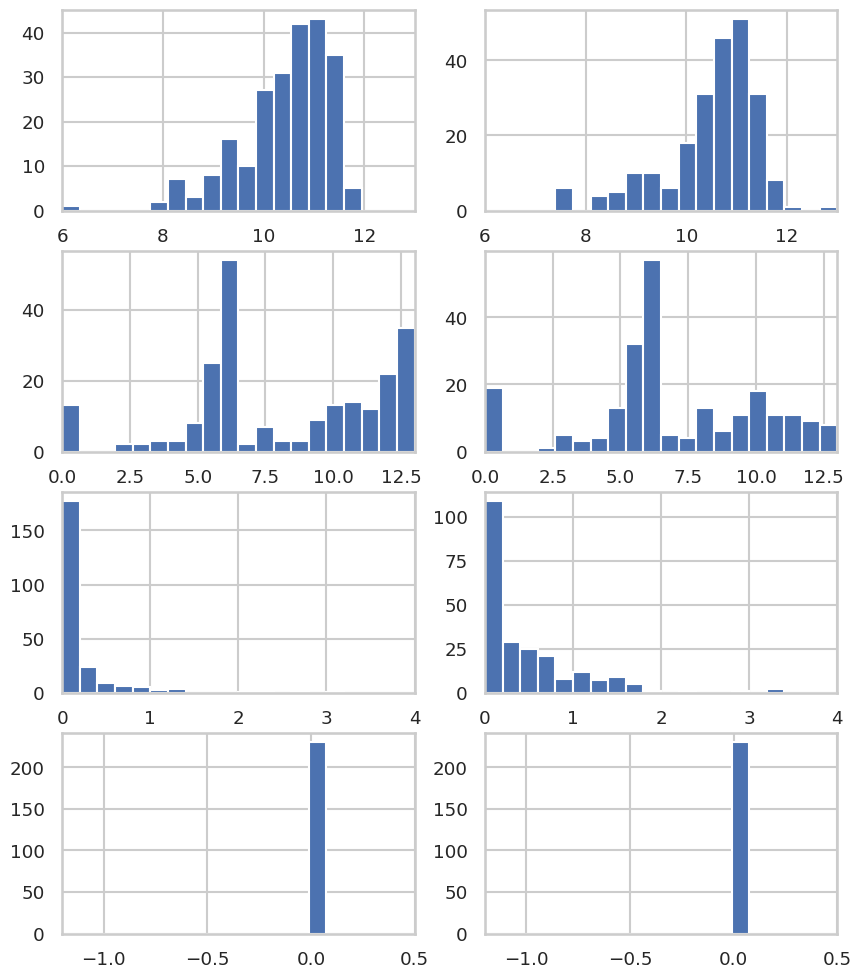

In [25]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
for ii, (prop, lim) in enumerate(zip(['LOGMSTAR', 'AGE', 'AV', 'ZZSUN'],
                                     [[6, 13], [0, 13], [0, 4], [-1.2, 0.5]])):
    ax[ii, 0].hist(fastphot[prop], range=lim, bins=20);
    ax[ii, 1].hist(fastspec[prop], range=lim, bins=20);
    for xx in ax[ii, :]:
        xx.set_xlim(lim)

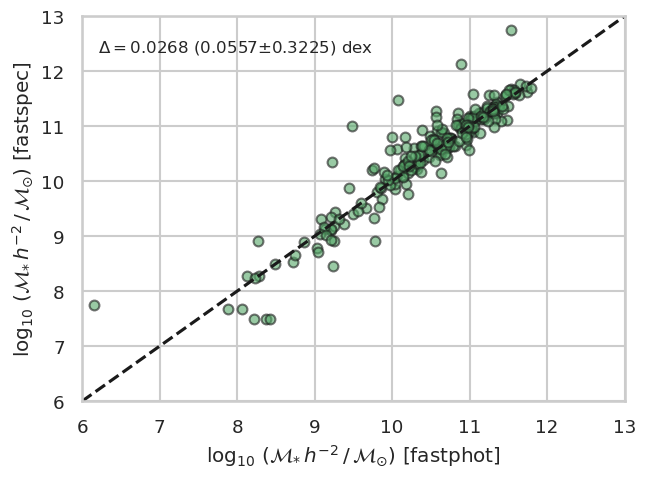

In [51]:
mstar_vs_mstar(fastphot['LOGMSTAR'], fastspec['LOGMSTAR'], 'fastphot', 'fastspec')

In [ ]:
mstar_vs_mstar(fastphot['LOGMSTAR'], fastspec['LOGMSTAR'], 'fastphot', 'fastspec')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
photsfr = np.zeros(len(fastphot)) + sfrlim[0] + 0.1
specsfr = np.zeros(len(fastspec)) + sfrlim[0] + 0.1

photsfr[fastphot['SFR'] > 0] = np.log10(fastphot['SFR'][fastphot['SFR'] > 0])
specsfr[fastspec['SFR'] > 0] = np.log10(fastspec['SFR'][fastspec['SFR'] > 0])

ax.scatter(photsfr, specsfr, s=50, marker='o', alpha=1., color=colors[0])
#print(np.median(fastphot['LOGMSTAR']-fastspec['LOGMSTAR']))
ax.plot(sfrlim, sfrlim, ls='--', color='k')
ax.set_xlim(sfrlim)
ax.set_ylim(sfrlim)
#ax.set_xlabel(get_masstitle(suffix='fastphot'));
#ax.set_ylabel(get_masstitle(suffix='fastspec'));

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'][indx_fast], hu['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label='fastphot')
ax.scatter(fastspec['LOGMSTAR'][indx_fast], hu['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label='fastspec')
print(np.median(fastphot['LOGMSTAR'][indx_fast]-hu['MSTAR']))
print(np.median(fastspec['LOGMSTAR'][indx_fast]-hu['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='FastSpecFit'));
ax.set_ylabel(get_masstitle(suffix='Hu'));
ax.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'], mar['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label='fastphot')
ax.scatter(fastspec['LOGMSTAR'], mar['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label='fastspec')
print(np.median(fastphot['LOGMSTAR']-mar['MSTAR']))
print(np.median(fastspec['LOGMSTAR']-mar['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='FastSpecFit'));
ax.set_ylabel(get_masstitle(suffix='Mar'));
ax.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'], delayed['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label=r'$delayed\ \tau$')
ax.scatter(fastphot['LOGMSTAR'], continuity['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label=r'$continuity$')
print(np.median(fastphot['LOGMSTAR']-delayed['MSTAR']))
print(np.median(fastphot['LOGMSTAR']-continuity['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastphot'));
ax.set_ylabel(get_masstitle(suffix='Prospector'));
ax.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2['Z'], out2['LOGMSTAR']-out2['LOGM'], s=50, alpha=1, color=colors[0])
#ax.plot([7, 12], [7, 12], ls='--', color='red')
ax.set_xlim(0, 0.6)
ax.set_ylim(-1, 2)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['AGE'], out2_zou['SED_AGE'], s=50, alpha=1, color=colors[0])
ax.plot([1, 14], [0.1, 14], ls='--', color='red')
ax.set_xlim(1, 14)
ax.set_ylim(1, 14)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['DN4000_MODEL'], out2_zou['AGE'], s=50, alpha=1, color=colors[0])
ax.scatter(out2_zou['DN4000_MODEL'], out2_zou['SED_AGE'], s=50, alpha=1, color=colors[1])
#ax.plot([1, 14], [0.1, 14], ls='--', color='red')
ax.set_xlim(0.8, 2.4)
#ax.set_ylim(1, 14)
#ax.set_xscale('log')
#ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['AV'], out2_zou['SED_AV'], s=50, alpha=1, color=colors[0])
ax.plot([0.001, 3], [0.001, 5], ls='--', color='red')
ax.set_xlim(0.001, 3)
ax.set_ylim(0.001, 3)
ax.set_xscale('log')
ax.set_yscale('log')